In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

In [6]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
# helper functions
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# Bengio et al. 2003 MLP language model paper
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# 4-gram solution
# using the two layer neural network : each character is embedded in a 2D space
# fed to a layer of 100 neurons, tanh activation
# followed by a final softmaxed layer of 27 neurons

In [196]:
C = torch.randn((27,10)) # embedding map
w1 = torch.randn((30, 200))
b1 = torch.randn((200,))
w2 = torch.randn((200, 27))
b2 = torch.randn((27,))
parameters = [C, w1, b1, w2, b2]

In [197]:
X = []
Y = []
block_size = 3
for w in words :
    context = [0]*block_size
    for i, c in enumerate(w + '.') :
        ix = stoi[c]
        l = [itos[cont] for cont in context]
        X.append(context)
        Y.append(ix)
#         print(''.join(l), '-->', c)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [198]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [199]:
for p in parameters :
    p.requires_grad = True
losslog = []

In [200]:

for i in range(200000) : # 100 epochs
    # taking batches 
    ix = torch.randint(0, X.shape[0], (32,))
    
    first = C[X[ix]].view(-1,30)
    second = first @ w1 + b1 # using broadcasting
    sec_act = second.tanh()
    third = sec_act @ w2 + b2
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(third, Y[ix])
    losslog.append(nll.item())
    
    # lr = 0.1 if i<100000 else 0.01
    for p in parameters :
        p.grad = None
    nll.backward()
    for p in parameters :
        p.data -= 0.1*p.grad
losslog[-1]

2.2110679149627686

In [202]:
# evaluating total loss
first = C[X].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nll = F.cross_entropy(third, Y)
nll

tensor(2.1781, grad_fn=<NllLossBackward>)

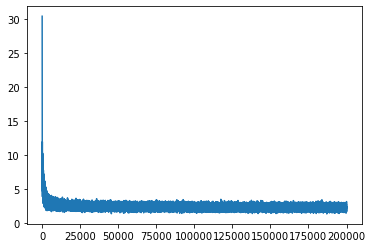

In [203]:
plt.plot(losslog)

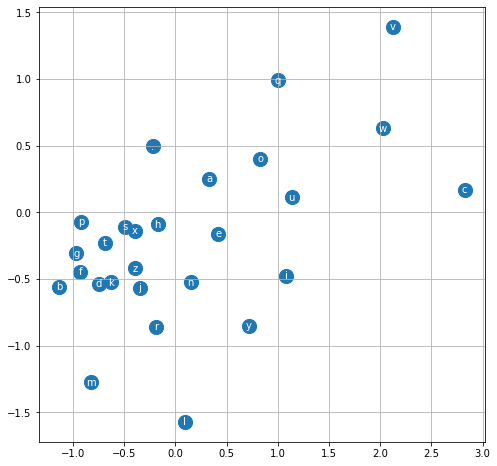

In [195]:
# visualizing embeddings (in case when embeddings are two dimensional)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [205]:
# sampling from the neural network
for p in parameters :
    p.requires_grad = False
for _ in range(5) :
    context = [0]*block_size
    while True :
        first = C[context].view(-1,30)
        second = first @ w1 + b1 # using broadcasting
        sec_act = second.tanh()
        logits = sec_act @ w2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if ix==0 : break
        print(itos[ix], end='')
        context = context[1:] + [ix]
    print()

alayla
zingtose
loya
emmario
emmiel


In [206]:
# Analysis

In [411]:
# record of improvements :
# Vanilla : 2.13 (train), 2.17(test)
# Diminishing initialisation of weights : 2.07(train), 2.12(test)
# kaiming init + batch norm : 2.06(train), 2.10(test)

In [11]:
block_size = 3
def build(words) :
    X = []
    Y = []
    for w in words :
        context = [0]*block_size
        for i, c in enumerate(w + '.') :
            ix = stoi[c]
            l = [itos[cont] for cont in context]
            X.append(context)
            Y.append(ix)
    #         print(''.join(l), '-->', c)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [12]:
# splitting into train and test(10%)
random.shuffle(words)
n = int(0.1*len(words))
Xtest, Ytest = build(words[:n])
Xtr, Ytr = build(words[n:])

In [13]:
Xtr.shape, Xtest.shape, Ytr.shape, Ytest.shape

(torch.Size([205338, 3]),
 torch.Size([22808, 3]),
 torch.Size([205338]),
 torch.Size([22808]))

In [262]:
C = torch.randn((27,10)) # embedding map
w1 = torch.randn((30, 200))
b1 = torch.randn((200,))
w2 = torch.randn((200, 27))
b2 = torch.randn((27,))
parameters = [C, w1, b1, w2, b2]

In [263]:
# Inital loss Vs eventual losses
for p in parameters :
    p.requires_grad = True
for i in range(200000) : # 100 epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    first = C[Xtr[ix]].view(-1,30)
    second = first @ w1 + b1 # using broadcasting
    sec_act = second.tanh()
    third = sec_act @ w2 + b2
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(third, Ytr[ix])
    losslog.append(nll.item())
    
    lr = 0.1 if i<100000 else 0.01
    for p in parameters :
        p.grad = None
    nll.backward()
    for p in parameters :
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step:{i:5d} / {200000} loss {nll:.7f}')

step:    0 / 200000 loss 24.1864853
step:10000 / 200000 loss 3.1529841
step:20000 / 200000 loss 2.6789651
step:30000 / 200000 loss 2.6973026
step:40000 / 200000 loss 2.5409193
step:50000 / 200000 loss 2.4454403
step:60000 / 200000 loss 2.6514771
step:70000 / 200000 loss 2.0421357
step:80000 / 200000 loss 2.1908629
step:90000 / 200000 loss 2.1112063
step:100000 / 200000 loss 2.8599601
step:110000 / 200000 loss 2.2066293
step:120000 / 200000 loss 2.4316037
step:130000 / 200000 loss 1.6215448
step:140000 / 200000 loss 2.0721536
step:150000 / 200000 loss 2.3134272
step:160000 / 200000 loss 1.9258155
step:170000 / 200000 loss 2.0965953
step:180000 / 200000 loss 2.0858028
step:190000 / 200000 loss 2.2787170


In [264]:
# Final train and test losses
first = C[Xtr].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltr = F.cross_entropy(third, Ytr)

first = C[Xtest].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltest = F.cross_entropy(third, Ytest)

print(f'Train : {nlltr.item()}, Test : {nlltest.item()}')

Train : 2.1371004581451416, Test : 2.17122745513916


In [213]:
# first loss is uncharacteristically higher than expected (around 3.3)
# this is because of the initialization of weights, causing high standard deviations, thus extreme values
# some iterations are wasted in this initial "squishing" of weights, thereby slowing training

In [265]:
C = torch.randn((27,10)) # embedding map
w1 = torch.randn((30, 200))
b1 = torch.randn((200,))
w2 = torch.randn((200, 27)) * 0.01
b2 = torch.randn((27,)) * 0
parameters = [C, w1, b1, w2, b2]

In [266]:
# Inital loss Vs eventual losses
for p in parameters :
    p.requires_grad = True
for i in range(200000) : # 100 epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    first = C[Xtr[ix]].view(-1,30)
    second = first @ w1 + b1 # using broadcasting
    sec_act = second.tanh()
    third = sec_act @ w2 + b2
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(third, Ytr[ix])
    losslog.append(nll.item())
    
    lr = 0.1 if i<100000 else 0.01
    for p in parameters :
        p.grad = None
    nll.backward()
    for p in parameters :
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step:{i:5d} / {200000} loss {nll:.7f}')

step:    0 / 200000 loss 3.3181572
step:10000 / 200000 loss 2.6614263
step:20000 / 200000 loss 2.1808941
step:30000 / 200000 loss 2.4896495
step:40000 / 200000 loss 2.1437504
step:50000 / 200000 loss 2.3840566
step:60000 / 200000 loss 2.2846386
step:70000 / 200000 loss 1.9885646
step:80000 / 200000 loss 2.1104343
step:90000 / 200000 loss 1.9112407
step:100000 / 200000 loss 2.2380536
step:110000 / 200000 loss 1.8407761
step:120000 / 200000 loss 2.4266548
step:130000 / 200000 loss 1.9268576
step:140000 / 200000 loss 2.0130789
step:150000 / 200000 loss 2.0451350
step:160000 / 200000 loss 1.5483993
step:170000 / 200000 loss 1.8644022
step:180000 / 200000 loss 2.1609235
step:190000 / 200000 loss 2.3194709


In [267]:
# Final train and test losses
first = C[Xtr].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltr = F.cross_entropy(third, Ytr)

first = C[Xtest].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltest = F.cross_entropy(third, Ytest)

print(f'Train : {nlltr.item()}, Test : {nlltest.item()}')

Train : 2.0719900131225586, Test : 2.1272692680358887


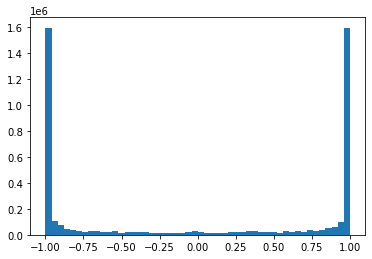

In [279]:
# with torch.no_grad() :
plt.hist(sec_act.view(-1).tolist(), bins=50);

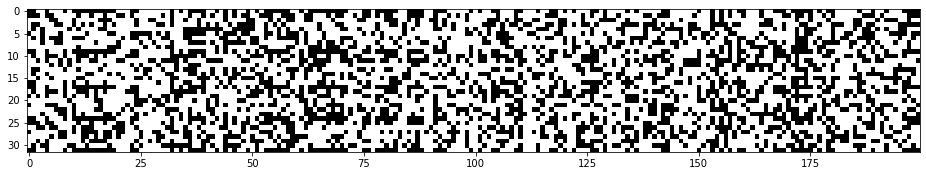

In [293]:
# As can be observed from the above, the majority of values lie close to the values -1,1
# these dont allow grads to flow through them
# making learning weaker
# Another visualization
temp = sec_act[:32,:] # taking a few of the samples to hasten plotting
plt.figure(figsize=(16,18))
plt.imshow(np.abs(temp.tolist())>0.99, cmap='gray')

In [294]:
# Here, the white neurons are the ones that lie on the tail of tanh
# have very weak grads
# A column of whites signifies a 'dead' neuron

# One solution to this is to diminish the weights going into tanh
# TO avoid extreme values, and thus, extreme activations

In [356]:
C = torch.randn((27,10)) # embedding map
w1 = torch.randn((30, 200)) * 0.002
b1 = torch.randn((200,)) * 0
w2 = torch.randn((200, 27)) * 0.01
b2 = torch.randn((27,)) * 0
parameters = [C, w1, b1, w2, b2]

In [357]:
# Inital loss Vs eventual losses
for p in parameters :
    p.requires_grad = True
for i in range(200001) : # 100 epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    first = C[Xtr[ix]].view(-1,30)
    second = first @ w1 + b1 # using broadcasting
    sec_act = second.tanh()
    third = sec_act @ w2 + b2
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(third, Ytr[ix])
    
    lr = 0.1 if i<100000 else 0.01
    for p in parameters :
        p.grad = None
    nll.backward()
    for p in parameters :
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step: {i:5d} / {200000} loss {nll:.7f}')

step:     0 / 200000 loss 3.2959986
step: 10000 / 200000 loss 2.2007847
step: 20000 / 200000 loss 2.4402485
step: 30000 / 200000 loss 1.8691388
step: 40000 / 200000 loss 2.2213502
step: 50000 / 200000 loss 2.2845044
step: 60000 / 200000 loss 2.3023355
step: 70000 / 200000 loss 1.7873470
step: 80000 / 200000 loss 2.5163295
step: 90000 / 200000 loss 2.4157367
step: 100000 / 200000 loss 2.0904024
step: 110000 / 200000 loss 2.3883312
step: 120000 / 200000 loss 2.0375731
step: 130000 / 200000 loss 2.4703317
step: 140000 / 200000 loss 1.9248964
step: 150000 / 200000 loss 1.9465374
step: 160000 / 200000 loss 2.3276615
step: 170000 / 200000 loss 2.5459678
step: 180000 / 200000 loss 2.3812885
step: 190000 / 200000 loss 2.1607807
step: 200000 / 200000 loss 2.2986231


In [367]:
# Final train and test losses
for p in parameters :
    p.requires_grad = False

first = C[Xtr].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltr = F.cross_entropy(third, Ytr)

first = C[Xtest].view(-1,30)
second = first @ w1 + b1 # using broadcasting
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltest = F.cross_entropy(third, Ytest)

print(f'Train : {nlltr.item()}, Test : {nlltest.item()}')

Train : 2.1066410541534424, Test : 2.138953447341919


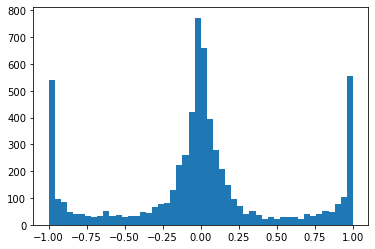

In [359]:
# with torch.no_grad() :
plt.hist(sec_act.view(-1).tolist(), bins=50);

In [365]:
work = np.abs(sec_act.view(-1).tolist())
len(work[work>0.99]) / len(work)

0.12109375

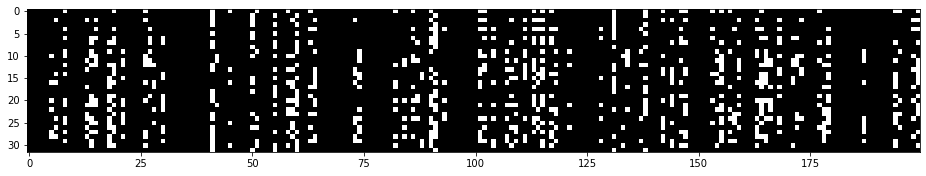

In [360]:
temp = sec_act[:32,:] # taking a few of the samples to hasten plotting
plt.figure(figsize=(16,18))
plt.imshow(np.abs(temp.tolist())>0.99, cmap='gray')

In [370]:
# Now adding kaiming initialization and batch normalisation
# Kaiming initialisation gives a natural way of initializing weights, instead of randomly trying numbers
# batch normalisation is used to tame the weights pre-activation, make them almost gaussian
# two additional hyper-parameters : bngain and bnbias : both of these are trainable

# we keep a running mean of the batch mean and std, to use during inference later

# Kaiming init : https://arxiv.org/abs/1502.01852
# batch norm : https://arxiv.org/abs/1502.03167

In [384]:
C = torch.randn((27,10)) # embedding map
w1 = torch.randn((30, 200)) * (5/3) / 30**0.5 # kaiming
# b1 = torch.randn((200,))  # not required due to batch norm
w2 = torch.randn((200, 27)) * 0.01
b2 = torch.randn((27,)) * 0

bngain = torch.ones((1,200))
bnbias = torch.zeros((1,200))

bnmean = torch.zeros((1,200))
bnstd = torch.ones((1,200))

parameters = [C, w1, w2, b2, bngain, bnbias]

In [385]:
# Inital loss Vs eventual losses
for p in parameters :
    p.requires_grad = True
for i in range(200001) : # 100 epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    first = C[Xtr[ix]].view(-1,30)
    second = first @ w1 # using broadcasting
    ### BATCH NORM ###
    batch_mean = second.mean(dim=0, keepdims=True)
    batch_std = second.std(dim=0, keepdims=True)
    
    normed_second = bngain*(second - batch_mean) / batch_std + bnbias
    with torch.no_grad() : # updating buffers
        bnmean = bnmean*0.999 + batch_mean*0.001
        bnstd = bnstd*0.999 + batch_std*0.001
    ##################
    sec_act = normed_second.tanh()
    third = sec_act @ w2 + b2
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(third, Ytr[ix])
    
    lr = 0.1 if i<100000 else 0.01
    for p in parameters :
        p.grad = None
    nll.backward()
    for p in parameters :
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step: {i:5d} / {200000} loss {nll:.7f}')

step:     0 / 200000 loss 3.2808344
step: 10000 / 200000 loss 2.1900401
step: 20000 / 200000 loss 2.1160254
step: 30000 / 200000 loss 2.3012125
step: 40000 / 200000 loss 2.7802513
step: 50000 / 200000 loss 2.2497087
step: 60000 / 200000 loss 1.9769011
step: 70000 / 200000 loss 2.2251384
step: 80000 / 200000 loss 2.2112033
step: 90000 / 200000 loss 2.5734949
step: 100000 / 200000 loss 2.2063670
step: 110000 / 200000 loss 2.4459829
step: 120000 / 200000 loss 1.9506277
step: 130000 / 200000 loss 1.9573561
step: 140000 / 200000 loss 2.1294024
step: 150000 / 200000 loss 1.7764113
step: 160000 / 200000 loss 1.8963950
step: 170000 / 200000 loss 1.8738066
step: 180000 / 200000 loss 2.0278599
step: 190000 / 200000 loss 2.6584454
step: 200000 / 200000 loss 2.3133371


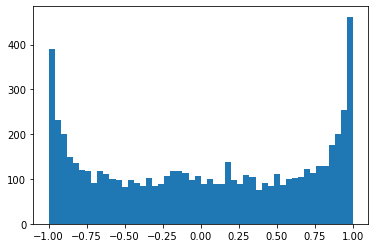

In [387]:
plt.hist(sec_act.view(-1).tolist(), bins=50);

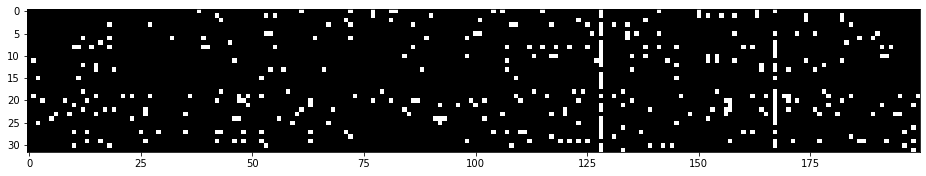

In [388]:
temp = sec_act[:32,:] # taking a few of the samples to hasten plotting
plt.figure(figsize=(16,18))
plt.imshow(np.abs(temp.tolist())>0.99, cmap='gray')

In [410]:
# Final train and test losses
for p in parameters :
    p.requires_grad = False

first = C[Xtr].view(-1,30)
second = first @ w1 # using broadcasting
second = bngain*(second - bnmean) / bnstd + bnbias
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltr = F.cross_entropy(third, Ytr)

first = C[Xtest].view(-1,30)
second = first @ w1 # using broadcasting
second = bngain*(second - bnmean) / bnstd + bnbias
sec_act = second.tanh()
third = sec_act @ w2 + b2
# logits = third.softmax(dim=1)
# nll = -logits[torch.arange(10), Y[:10]].log().mean()
nlltest = F.cross_entropy(third, Ytest)

print(f'Train : {nlltr.item()}, Test : {nlltest.item()}')

Train : 2.069880247116089, Test : 2.1058051586151123


In [412]:
# torchifying the code, and grad analysis

In [258]:
class Linear :
    def __init__(self, fanin, fanout, bias=True) :
        self.w = torch.randn((fanin, fanout), generator=g) / fanin**0.5 # the division preserves std, also implemented in pytorch
        self.b = torch.randn((fanout,)) if bias else None
    def __call__(self, x) :
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    def parameters(self) :
        return [self.w] + ([self.b] if self.b is not None else [])
    
class BatchNorm1d :
    def __init__(self, dim, eps=1e-5, momentum=0.1) :
        self.eps = eps
        self.momentum = momentum
        self.training = True # since batch norm internals work differently during training and inference
        self.gamma = torch.ones(dim) # batch norm gain
        self.beta = torch.zeros(dim) # batch norm bias
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x) :
        if self.training :
            mean = x.mean(0, keepdims=True)
            var = x.var(0, keepdims=True)
        else :
            mean = self.running_mean
            var = self.running_var
        self.out = self.gamma*(x - mean) / torch.sqrt(var+self.eps) + self.beta
        
        if self.training :
            with torch.no_grad() :
                self.running_mean = self.running_mean*(1-self.momentum) + mean*self.momentum
                self.running_var = self.running_var*(1-self.momentum) + var*self.momentum
        return self.out
    def parameters(self) :
        return [self.gamma, self.beta]
    
class Tanh :
    def __call__(self, x) :
        self.out = x.tanh()
        return self.out
    def parameters(self) :
        return []

In [241]:
embed_shape = 10
nhidden = 200
block_size = 3
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((27,embed_shape), generator=g) # embedding map
layers = [
    Linear(block_size*embed_shape, nhidden), Tanh(),
    Linear(nhidden               , nhidden), Tanh(),
    Linear(nhidden               , nhidden), Tanh(),
    Linear(nhidden               , nhidden), Tanh(),
    Linear(nhidden               , nhidden), Tanh(),
    Linear(nhidden               , 27)
] # layers of the network

with torch.no_grad() :
    layers[-1].w *= 0.1 # lowering the confidence in the final layer
    for layer in layers[:-1] :
        if isinstance(layer, Linear) :
            layer.w *= (5/3) # gain for tanh
params = [C] + [p for layer in layers for p in layer.parameters()]
for p in params :
    p.requires_grad = True
    
# one rationale for the gain multiplication
# due to the division by sqrt(fanin) in the weight layers, the std deviation of the inputs is preserved in the outputs
# thus, a series of linear layers would preserve the std deviation
# however, tanh is a squashing function and tends to lower the std deviation
# in anticipation, we multiply the weights appropriately so that std deviation is maintained

# the 5/3 comes from the fact that tanh converts an input with variance 1 to an output with variance ~0.39, obtained by
# integrating tanh(x)^2 N(x; 0,1) dx from -infinity to infinity
# similarly, gain for relu is sqrt(2)

# note : not exactly variance, but E[x^2] in the above paragraph :)

In [238]:

ud = []
for i in range(200001) : # of epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
    
    x = C[Xtr[ix]].view(-1,embed_shape*3)
    for layer in layers :
        x = layer(x) # forward pass
    
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(x, Ytr[ix])
    for layer in layers :
        layer.out.retain_grad() # retains the grad to be able to plot later
# usually non-leaf params do not have their .grad attrbutes populated, since they are almost never required
# they just pass grads downwards
# to be able to access these later, we need retain_grad
    
    lr = 0.1 if i<100000 else 0.01
    for p in params :
        p.grad = None
    nll.backward()
    for p in params :
#         print(p.shape)
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step: {i:5d} / {200000} loss {nll:.7f}')
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])
    if i>1000 : break

step:     0 / 200000 loss 4.3475680


Layer 1 | mean +0.02 | std 0.79 | saturation 15.59375 %
Layer 3 | mean -0.07 | std 0.75 | saturation 8.015625 %
Layer 5 | mean -0.01 | std 0.76 | saturation 10.21875 %
Layer 7 | mean -0.04 | std 0.78 | saturation 10.640625 %
Layer 9 | mean +0.00 | std 0.68 | saturation 4.59375 %


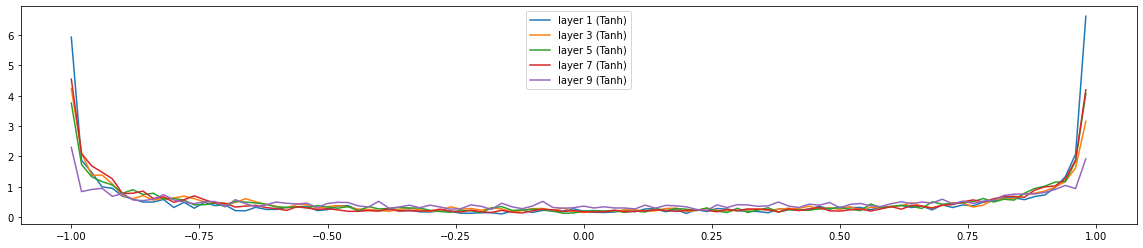

In [223]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers) :
    if isinstance(layer, Tanh) :
        t = layer.out
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        print(f'Layer {i} | mean {t.mean():+.2f} | std {t.std():.2f} | saturation {100 * t[t>0.97].shape[0] / t.view(-1).shape[0]} %')
#         print(t.shape)
plt.legend(legends)
plt.show()

Layer 1 | mean -0.00001 | std 0.00160 
Layer 3 | mean +0.00000 | std 0.00160 
Layer 5 | mean +0.00000 | std 0.00164 
Layer 7 | mean +0.00001 | std 0.00174 
Layer 9 | mean +0.00001 | std 0.00151 


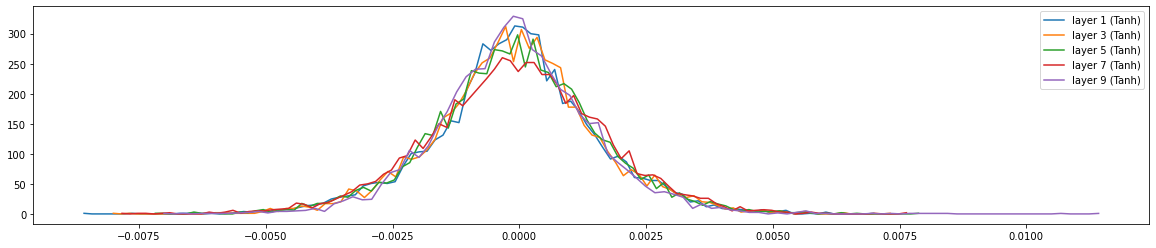

In [224]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers) :
    if isinstance(layer, Tanh) :
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        print(f'Layer {i} | mean {t.mean():+.5f} | std {t.std():.5f} ')
#         print(t.shape)
plt.legend(legends)
plt.show()

weight torch.Size([27, 10]) | mean -0.02 | std 1.01 | grad-data ratio 0.00881046149879694
weight torch.Size([30, 200]) | mean +0.00 | std 0.31 | grad-data ratio 0.015977950766682625
weight torch.Size([200, 200]) | mean -0.00 | std 0.12 | grad-data ratio 0.035017430782318115
weight torch.Size([200, 200]) | mean -0.00 | std 0.12 | grad-data ratio 0.03322671726346016
weight torch.Size([200, 200]) | mean -0.00 | std 0.12 | grad-data ratio 0.03125481307506561
weight torch.Size([200, 200]) | mean +0.00 | std 0.12 | grad-data ratio 0.032601434737443924
weight torch.Size([200, 27]) | mean +0.00 | std 0.05 | grad-data ratio 0.4744057059288025


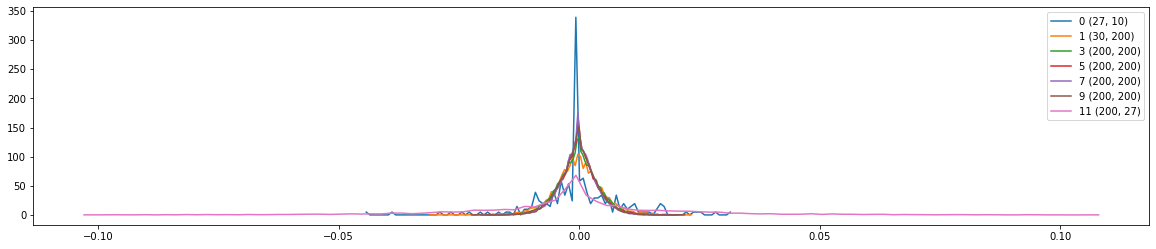

In [225]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(params) :
    if p.ndim==2 : # only looking at the weight params
        t = p.grad
        hy, hx = torch.histogram(t, density=True)
        print(f'weight {p.shape} | mean {p.mean():+.2f} | std {p.std():.2f} | grad-data ratio {t.std()/p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.show()

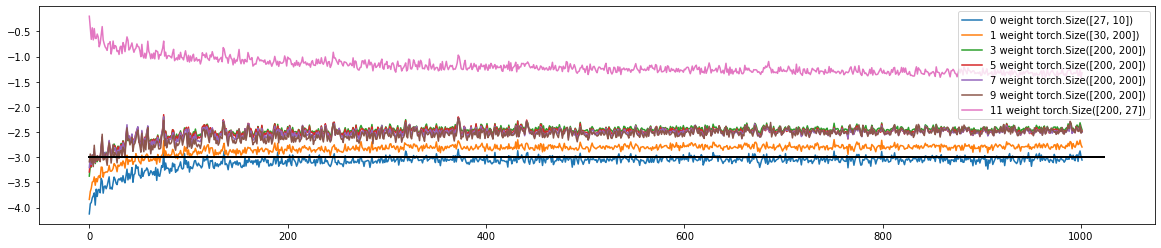

In [226]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(params) :
    if p.ndim==2 : # only looking at the weight params
        plt.plot(np.array(ud)[:,i], label=f'{i} weight {p.shape}')
    plt.plot(np.arange(1024), [-3]*1024, c='k')
plt.legend()
plt.show()

In [172]:
# adding batch normalisation brings robustness against variations in scaling parameters
# otherwise, training a network is like balancing a pencil on a finger
# you need to get all hyper-parameters just right to be able to train optimally

# additionally, note that the saturation percentage is too high in the first plot
# this is rectified by the use of batchnorm, as shown next

(1002,)

In [266]:
embed_shape = 10
nhidden = 200
block_size = 3
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((27,embed_shape), generator=g) # embedding map
layers = [
    Linear(block_size*embed_shape, nhidden, bias=False), BatchNorm1d(nhidden), Tanh(),
    Linear(nhidden               , nhidden, bias=False), BatchNorm1d(nhidden), Tanh(),
    Linear(nhidden               , nhidden, bias=False), BatchNorm1d(nhidden), Tanh(),
    Linear(nhidden               , nhidden, bias=False), BatchNorm1d(nhidden), Tanh(),
    Linear(nhidden               , nhidden, bias=False), BatchNorm1d(nhidden), Tanh(),
    Linear(nhidden               , 27, bias=False), BatchNorm1d(27)
] # layers of the network

with torch.no_grad() :
    layers[-1].gamma *= 0.1 # serves the same purpose
#     layers[-2].w *= 0.1 # lowering the confidence in the final layer
    for layer in layers[:-2] :
        if isinstance(layer, Linear) :
            layer.w *= 1 # (5/3) # gain for tanh, not required anymore
params = [C] + [p for layer in layers for p in layer.parameters()]
for p in params :
    p.requires_grad = True

In [267]:

ud = []
for i in range(200001) : # of epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
    
    x = C[Xtr[ix]].view(-1,embed_shape*3)
    for layer in layers :
        x = layer(x) # forward pass
    
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(x, Ytr[ix])
    for layer in layers :
        layer.out.retain_grad() # retains the grad to be able to plot later
# usually non-leaf params do not have their .grad attrbutes populated, since they are almost never required
# they just pass grads downwards
# to be able to access these later, we need retain_grad
    
    lr = 0.1 if i<100000 else 0.01
    for p in params :
        p.grad = None
    nll.backward()
    for p in params :
#         print(p.shape)
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step: {i:5d} / {200000} loss {nll:.7f}')
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])
    if i>1000 : break

step:     0 / 200000 loss 3.2712777


Layer 2 | mean -0.00 | std 0.63 | saturation 1.453125 %
Layer 5 | mean -0.00 | std 0.64 | saturation 1.296875 %
Layer 8 | mean +0.00 | std 0.64 | saturation 1.203125 %
Layer 11 | mean +0.00 | std 0.65 | saturation 0.984375 %
Layer 14 | mean +0.00 | std 0.65 | saturation 1.015625 %


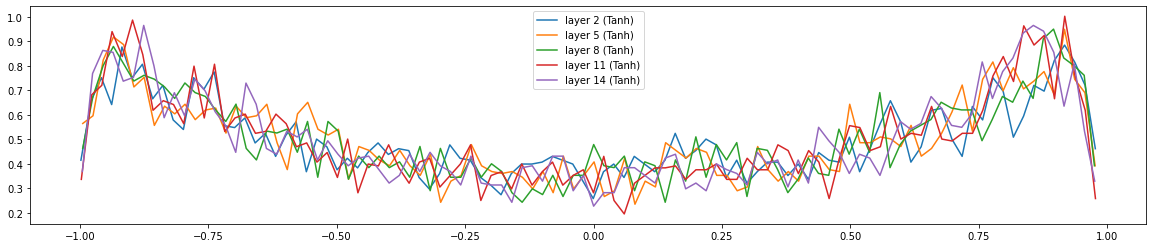

In [268]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers) :
    if isinstance(layer, Tanh) :
        t = layer.out
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        print(f'Layer {i} | mean {t.mean():+.2f} | std {t.std():.2f} | saturation {100 * t[t>0.97].shape[0] / t.view(-1).shape[0]} %')
#         print(t.shape)
plt.legend(legends)
plt.show()

Layer 2 | mean -0.00000 | std 0.00158 
Layer 5 | mean +0.00000 | std 0.00132 
Layer 8 | mean -0.00000 | std 0.00121 
Layer 11 | mean +0.00000 | std 0.00111 
Layer 14 | mean +0.00000 | std 0.00107 


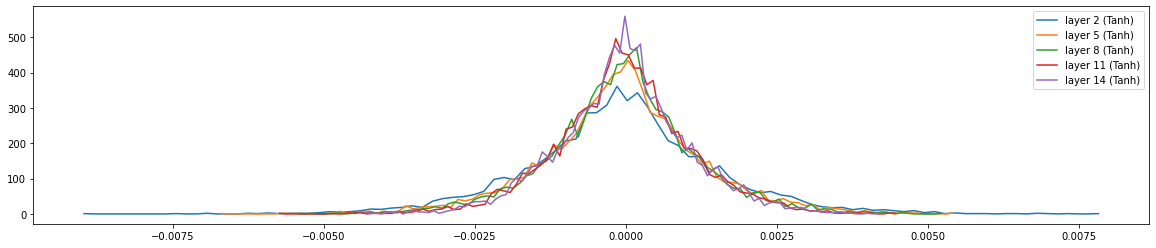

In [269]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers) :
    if isinstance(layer, Tanh) :
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        print(f'Layer {i} | mean {t.mean():+.5f} | std {t.std():.5f} ')
#         print(t.shape)
plt.legend(legends)
plt.show()

weight torch.Size([27, 10]) | mean -0.02 | std 1.00 | grad-data ratio 0.00995731446892023
weight torch.Size([30, 200]) | mean +0.00 | std 0.19 | grad-data ratio 0.03726589307188988
weight torch.Size([200, 200]) | mean -0.00 | std 0.07 | grad-data ratio 0.06852561980485916
weight torch.Size([200, 200]) | mean -0.00 | std 0.07 | grad-data ratio 0.05641217902302742
weight torch.Size([200, 200]) | mean -0.00 | std 0.07 | grad-data ratio 0.04855289310216904
weight torch.Size([200, 200]) | mean +0.00 | std 0.07 | grad-data ratio 0.044155303388834
weight torch.Size([200, 27]) | mean -0.00 | std 0.08 | grad-data ratio 0.1145099550485611


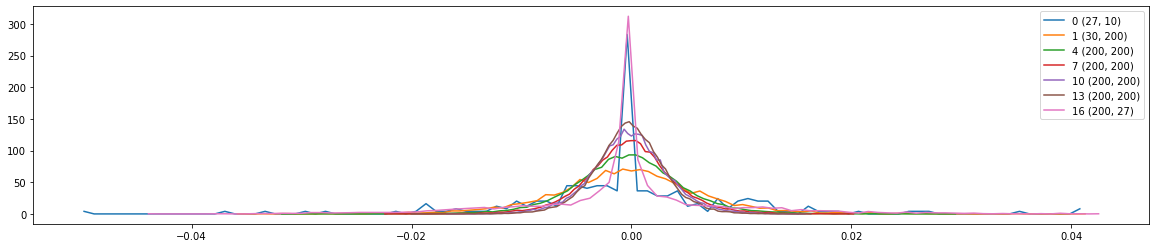

In [270]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(params) :
    if p.ndim==2 : # only looking at the weight params
        t = p.grad
        hy, hx = torch.histogram(t, density=True)
        print(f'weight {p.shape} | mean {p.mean():+.2f} | std {p.std():.2f} | grad-data ratio {t.std()/p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.show()

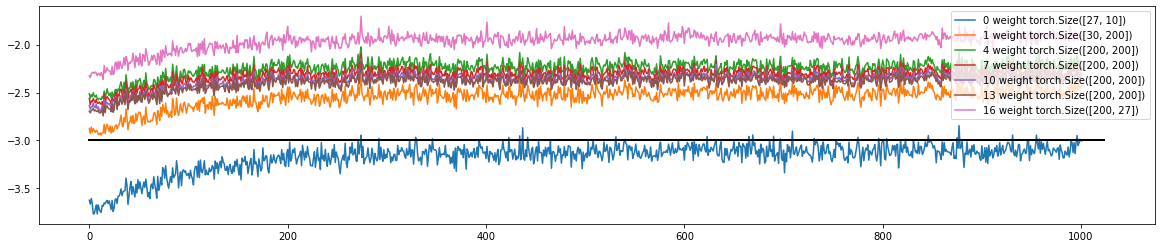

In [271]:
# visualizing output of tanh
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(params) :
    if p.ndim==2 : # only looking at the weight params
        plt.plot(np.array(ud)[:,i], label=f'{i} weight {p.shape}')
    plt.plot(np.arange(1024), [-3]*1024, c='k')
plt.legend()
plt.show()